# Softmax 回归
* softmax 回归是一个多类分类模型
* 使用 softmax 函数将模型输出转换为概率分布
* 使用交叉熵来衡量预测和标号的区别

In [1]:
# Fashion - MNIST 数据集

import torch
import torchvision
from torch.utils import data
from torchvision import transforms
from d2l import torch as d2l

from practice.linear_regression.linear_regression import num_epochs

d2l.use_svg_display()

In [2]:
# 通过 ToTensor 实例将图像数据从PIL 类型转换为 32 位浮点数格式
# 并除以 255 是的所有的像素值均在 0 到 1 之间
trans = transforms.ToTensor()
mnist_train = torchvision.datasets.FashionMNIST(
    root = "data", train = True, transform = trans, download = True
)
mnist_test = torchvision.datasets.FashionMNIST(
    root = "data", train = False, transform = trans, download = True
)
len(mnist_train), len(mnist_test)

(60000, 10000)

In [3]:
mnist_train[0][0].shape

torch.Size([1, 28, 28])

array([<Axes: title={'center': 'ankle boot'}>,
       <Axes: title={'center': 't-shirt'}>,
       <Axes: title={'center': 't-shirt'}>,
       <Axes: title={'center': 'dress'}>,
       <Axes: title={'center': 't-shirt'}>,
       <Axes: title={'center': 'pullover'}>,
       <Axes: title={'center': 'sneaker'}>,
       <Axes: title={'center': 'pullover'}>,
       <Axes: title={'center': 'sandal'}>,
       <Axes: title={'center': 'sandal'}>,
       <Axes: title={'center': 't-shirt'}>,
       <Axes: title={'center': 'ankle boot'}>,
       <Axes: title={'center': 'sandal'}>,
       <Axes: title={'center': 'sandal'}>,
       <Axes: title={'center': 'sneaker'}>,
       <Axes: title={'center': 'ankle boot'}>,
       <Axes: title={'center': 'trouser'}>,
       <Axes: title={'center': 't-shirt'}>], dtype=object)

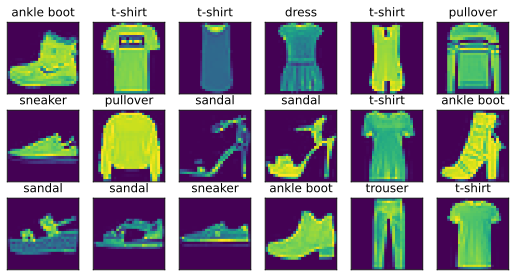

In [4]:
def get_fashion_mnist_labels(labels):
    text_labels = [
        "t-shirt", "trouser", "pullover", "dress", "coat",
        "sandal", "shirt", "sneaker", "bag", "ankle boot"
    ]
    return [text_labels[int(i)] for i in labels] # 将数字标签转成文本标签

def show_images(imgs, num_rows, num_cols, titles = None, scale = 1.5):
    figsize = (num_cols * scale, num_rows * scale)
    _, axes = d2l.plt.subplots(num_rows, num_cols, figsize = figsize)
    axes = axes.flatten()
    for i, (ax, img) in enumerate(zip(axes, imgs)):
        if torch.is_tensor(img):
            # 图片张量
            ax.imshow(img.numpy())
        else:
            # PIL 图片
            ax.imshow(img)
        if titles:
            ax.set_title(titles[i])
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
    return axes

X, y = next(iter(data.DataLoader(mnist_train, batch_size=18)))
show_images(X.reshape(18, 28, 28), 3, 6, titles = get_fashion_mnist_labels(y))

In [5]:
batch_size = 256

def get_dataloader_workers():
    return 4 # 使用4个进程来读取数据

train_iter = data.DataLoader(mnist_train, batch_size, shuffle=True,
                                num_workers=get_dataloader_workers())
timer = d2l.Timer()
for X, y in train_iter:
    continue
f'{timer.stop():.2f}'

'5.36'

In [6]:
def load_data_fashion_mnist(batch_size, resize = None):
    # 下载 Fashion-MNIST 数据集，然后加载到内存中
    trans = [transforms.ToTensor]
    if resize: # 是否需要调整图像
        trans.insert(0, transforms.Resize(resize))
    trans = transforms.Compose(trans)
    mnist_train = torchvision.datasets.FashionMNIST(
        root = "data", train = True, transform = trans, download = True
    )
    mnist_test = torchvision.datasets.FashionMNIST(
        root = "data", train = False, transform = trans, download = True
    )
    return (data.DataLoader(mnist_train, batch_size, shuffle=True,
                            num_workers=get_dataloader_workers()),
            data.DataLoader(mnist_test, batch_size, shuffle=False,
                            num_workers=get_dataloader_workers()))

### 从零开始实现 softmax 回归

In [14]:
import torch
from IPython import display

batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)

```
将展平每个图像，将他们是为长度为784的向量（28 x 28 = 784）。
因为我们的数据集有 10 个类别，所以网络输出层的大小为 10。
```

In [19]:
from d2l.torch import Accumulator

# 3. 重新初始化参数（重建 W 和 b，确保维度匹配）
num_inputs = 784  # 28*28
num_outputs = 10
W = torch.normal(0, 0.01, size=(num_inputs, num_outputs), requires_grad=True)
b = torch.zeros(num_outputs, requires_grad=True)

# 4. 模型与工具函数
def softmax(X):
    X_exp = torch.exp(X)
    partition = X_exp.sum(dim=1, keepdim=True)
    return X_exp / partition

def net(X):
    X = X.reshape(-1, W.shape[0])
    return softmax(torch.matmul(X, W) + b)  # b 形状 (num_outputs,) 会广播

def cross_entropy(y_hat, y):
    return -torch.log(y_hat[range(len(y_hat)), y])

def accuracy(y_hat, y):
    # 兼容 logits/probs (batch,num_classes) 与 label (batch,)
    if y_hat.ndim > 1 and y_hat.shape[1] > 1:
        y_hat = y_hat.argmax(dim=1)
    if y.ndim > 1 and y.shape[1] > 1:
        y = y.argmax(dim=1)
    y_hat = y_hat.reshape(-1).long()
    y = y.reshape(-1).long()
    return float((y_hat == y).sum().item())

def evaluate_accuracy(net, data_iter):
    if isinstance(net, torch.nn.Module):
        net.eval()
    metric = Accumulator(2)  # [正确数, 样本总数]
    with torch.no_grad():
        for X, y in data_iter:
            y_hat = net(X)
            metric.add(accuracy(y_hat, y), y.numel())
    return metric[0] / metric[1]

# 5. 验证输出形状然后评估
for X_test, y_test in test_iter:
    y_hat = net(X_test)
    print("net(X) shape:", y_hat.shape)  # 期望: (batch_size, num_outputs)
    print("y shape:", y_test.shape)      # 期望: (batch_size,)
    break

acc = evaluate_accuracy(net, test_iter)
print("准确率:", acc)

net(X) shape: torch.Size([256, 10])
y shape: torch.Size([256])
准确率: 0.1515


In [42]:
# Softmax 回归的训练
def train_epoch_ch3(net, train_iter, loss, updater):  #@save
    """训练模型一个迭代周期（定义见第3章）"""
    # 将模型设置为训练模式
    if isinstance(net, torch.nn.Module):
        net.train()
    # 训练损失总和、训练准确度总和、样本数
    metric = Accumulator(3)
    for X, y in train_iter:
        # 计算梯度并更新参数
        y_hat = net(X)
        l = loss(y_hat, y)
        if isinstance(updater, torch.optim.Optimizer):
            # 使用PyTorch内置的优化器和损失函数
            updater.zero_grad()
            l.mean().backward()
            updater.step()
        else:
            # 使用定制的优化器和损失函数
            l.sum().backward()
            updater(X.shape[0])
        metric.add(float(l.sum()), accuracy(y_hat, y), y.numel())
    # 返回训练损失和训练精度
    return metric[0] / metric[2], metric[1] / metric[2]


In [43]:
# 定义一个在动画中绘制数据的实用程序类
class Animator:
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1,
                 figsize=(3.5, 2.5)):
        if legend is None:
            legend = []
        d2l.use_svg_display()
        self.fig, self.axes = d2l.plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes, ]
        self.config_axes = lambda: d2l.set_axes(
            self.axes[0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend
        )
        self.X, self.Y, self.fmts = [], [], fmts

    def add(self, x, y):
        # 向图表中添加多个数据点
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)

In [45]:
# 训练行数
def train_ch3(net, train_iter, test_iter, loss, num_epochs, updater):
    animator = Animator(xlabel='epoch', xlim=[1, num_epochs],
                        ylim=[0.3, 0.9],
                        legend=['train loss', 'train acc', 'test acc'])
    for epoch in range(num_epochs):
        train_metrics = train_epoch_ch3(net, train_iter, loss, updater)
        test_acc = evaluate_accuracy(net, test_iter)
        animator.add(epoch + 1, train_metrics + (test_acc,))
    train_loss, train_acc = train_metrics

In [46]:
# 小批量随机梯度下降
lr = 0.1

def updater(batch_size):
    return d2l.sgd([W, b], lr, batch_size)

In [47]:
num_epochs = 10
train_ch3(net, train_iter, test_iter, cross_entropy, num_epochs, updater)

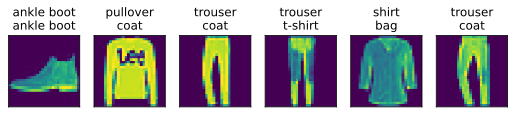

In [39]:
# 对图像进行分类
def predict_ch3(net, test_iter, n=6):
    for X, y in test_iter:
        break
    trues = d2l.get_fashion_mnist_labels(y)
    preds = d2l.get_fashion_mnist_labels(net(X).argmax(axis=1))
    titles = [true + '\n' + pred for true, pred in zip(trues, preds)]
    d2l.show_images(X[0:n].reshape(n, 28, 28), 1, n, titles=titles[0:n])
predict_ch3(net, test_iter)

In [48]:
# Softmax 回归的简洁实现
import torch
from torch import nn
from d2l import torch as d2l

batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
net = nn.Sequential(nn.Flatten(), nn.Linear(784, 10))

def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, std=0.01)

net.apply(init_weights);

loss = nn.CrossEntropyLoss(reduction='none')
trainer = torch.optim.SGD(net.parameters(), lr=0.1)

num_epochs = 10
train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)